<a href="https://colab.research.google.com/github/MaimomAlbert/Twitter-Sentiment_Analysis/blob/main/Feedforward.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# utils
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

# Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

# keras
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import set_random_seed

# sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

set_random_seed(13)

data preprocessing

In [ ]:
X = np.load('/content/drive/MyDrive/twitter_Sentiment_Analysis_MLP/dataset/feature_vectors_neg.npy', allow_pickle=True)
y = np.load('/content/drive/MyDrive/twitter_Sentiment_Analysis_MLP/dataset/target_vectors_neg.npy', allow_pickle=True)

splitting the dataset into train, test and validation

In [ ]:
X_train_split, X_test_split, y_train, y_test = train_test_split(X, y, train_size=0.9, random_state=13)
X_test_split, X_val_split, y_test, y_val = train_test_split(X_test_split, y_test, train_size=0.5, random_state=13)

print("Train set size:", X_train_split.shape[0])
print("Test set size", X_test_split.shape[0])
print("Validation set size", X_val_split.shape[0])

Train set size: 1431702
Test set size 79539
Validation set size 79539


tokanizer: give index to the vocad
tokinizer.text_to_sequence:convert the text into its respeective index present in the vocab

In [ ]:
# Initiate Keras tokenizer and vectorizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train_split)

# Transfrom X into vectorized values
X_train_transformed = tokenizer.texts_to_sequences(X_train_split)
X_val_transformed = tokenizer.texts_to_sequences(X_val_split)
X_test_transformed = tokenizer.texts_to_sequences(X_test_split)

# View vocabulary size
print("Vocabulary size: ", len(tokenizer.word_index))

Vocabulary size:  235887


In [ ]:
X_train_split[0]

'wish could say yum NEGlike fruit'

In [ ]:
X_train_transformed[0]

[45, 44, 90, 783, 323, 2166]

assinging (0,1) to the level label in our case 4>0 =1 ,0=0

In [ ]:
label_encoder = LabelEncoder()

# Transform y into numerical values (0, 1)
y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)
y_test = label_encoder.transform(y_test)

In [ ]:
y_train

array([0, 1, 0, ..., 0, 1, 1])

In [ ]:
y_val

array([1, 1, 0, ..., 1, 1, 1])

In [ ]:
print('Statistics summary of vector lengths in X_transformed: ')
pd.Series([len(text.split()) for text in X]).describe(percentiles=[.25, .5, .75, .9, .975]).apply("{0:.2f}".format)

Statistics summary of vector lengths in X_transformed: 


count    1590780.00
mean           6.83
std            3.77
min            1.00
25%            4.00
50%            6.00
75%            9.00
90%           12.00
97.5%         15.00
max           50.00
dtype: object

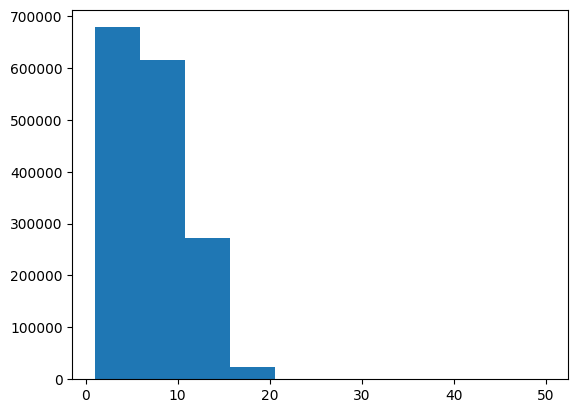

In [ ]:
plt.hist([len(text.split()) for text in X])
plt.show()

padding and trauncatination:pre and post padding

In [ ]:
X_train_transformed = pad_sequences(X_train_transformed, maxlen=25, padding='post', truncating='post')
X_val_transformed = pad_sequences(X_val_transformed, maxlen=25, padding='post', truncating='post')
X_test_transformed = pad_sequences(X_test_transformed, maxlen=25, padding='post', truncating='post')

print('Statistics summary of vector lengths in X_transformed: ')
pd.Series([len(text) for text in X_train_transformed]).describe().apply("{0:.2f}".format)

Statistics summary of vector lengths in X_transformed: 


count    1431702.00
mean          25.00
std            0.00
min           25.00
25%           25.00
50%           25.00
75%           25.00
max           25.00
dtype: object

converting into tensor and reshaping the dimension i.e into row dimension

In [ ]:
train_set = TensorDataset(torch.tensor(X_train_transformed), torch.tensor(y_train).reshape(-1, 1))
val_set = TensorDataset(torch.tensor(X_val_transformed), torch.tensor(y_val).reshape(-1, 1))
test_set = TensorDataset(torch.tensor(X_test_transformed), torch.tensor(y_test).reshape(-1, 1))

train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
val_loader = DataLoader(val_set, batch_size=128)
test_loader = DataLoader(test_set, batch_size=128)

In [ ]:
tokenizer.word_index.items()

dict_items([('day', 1), ('good', 2), ('going', 3), ('like', 4), ('quot', 5), ('got', 6), ('get', 7), ('go', 8), ('today', 9), ('love', 10), ('cannot', 11), ('work', 12), ('lol', 13), ('back', 14), ('time', 15), ('one', 16), ('amp', 17), ('want', 18), ('really', 19), ('night', 20), ('oh', 21), ('still', 22), ('thanks', 23), ('would', 24), ('see', 25), ('well', 26), ('new', 27), ('know', 28), ('home', 29), ('miss', 30), ('think', 31), ('last', 32), ('tomorrow', 33), ('much', 34), ('morning', 35), ('need', 36), ('hope', 37), ('great', 38), ('twitter', 39), ('though', 40), ('haha', 41), ('sad', 42), ('way', 43), ('could', 44), ('wish', 45), ('right', 46), ('feel', 47), ('fun', 48), ('sorry', 49), ('tonight', 50), ('happy', 51), ('bad', 52), ('people', 53), ('getting', 54), ('yeah', 55), ('come', 56), ('better', 57), ('nice', 58), ('watching', 59), ('bed', 60), ('sleep', 61), ('make', 62), ('week', 63), ('us', 64), ('school', 65), ('hey', 66), ('yes', 67), ('days', 68), ('hate', 69), ('soon

# fastext word embedding
Covert into vector form

In [ ]:
from gensim.models import KeyedVectors
kv_model = KeyedVectors.load_word2vec_format('/content/drive/MyDrive/twitter_Sentiment_Analysis_MLP/dataset/crawl-300d-2M.vec')

In [ ]:
VOCAB_SIZE = len(tokenizer.word_index) + 1
EMBEDDINGS_DIM = 300

Making embiding matrix

In [ ]:
# Initiate an empty matrix as a embeddings container
embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDINGS_DIM))

# Loading GloVe weights into our embedding matrix
for word, index in tokenizer.word_index.items():
  if word in kv_model:
    embedding_matrix[index] = kv_model[word].copy()

embedding_matrix = torch.FloatTensor(embedding_matrix)

In [ ]:
# The output of the model [0, 1]
OUTPUT_SIZE = 1
# The size of the hidden layers (how many neural nodes to use)
HIDDEN_SIZE = 512
# Batch size
BATCH_SIZE = 128
# Number of epochs
NUM_EPOCHS = 50

changing the device

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


BUILDING NEURAL ** **bold text**NETWORK**
 The model we are building will have 2 hidden layers, which will have 512 and 256 hidden nodes respectively, and 1 output layers. Additionally, we also employ 1 embedding layers to transform our input sequence into word embeddings.

Given that the word embeddings will create a vector for each token, we need to find a way to aggregate the vectors into one single vector (pooling), representing the whole sentence. There are many different approach to this (taking the mean of the vectors, etc.), but for this, we would like to sum them up, because our data might have many OOVs, which cause the word embeddings to be all zeros. Because of this, we do not want the OOVs to affect the representation of the full sentence from taking the mean.

We are also interested in applying drop-out to regularize the model, ensuring that there is a lower chance of overfitting. As its name, the main idea of this is to randomly drop out a percentage of all connections between layers, therefore ensuring that the model only learns to generalize features but not to replicate them.

[ ]
## New Section

In [ ]:
class FeedForward(nn.Module):
  def __init__(self, output_size, embedding_dim, hidden_size, dropout=0.5):
    super(FeedForward, self).__init__()
    self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=True)
    self.linear_stack = nn.Sequential(
      nn.Linear(in_features=embedding_dim, out_features=hidden_size),
      nn.ReLU(),
      nn.Dropout(p=dropout),
      nn.Linear(in_features=hidden_size, out_features=hidden_size//2),
      nn.ReLU(),
      nn.Linear(in_features=hidden_size//2, out_features=output_size, bias=False),
      nn.Sigmoid()
    )

  def forward(self, input):
    emb = self.embedding(input)
    emb = torch.sum(emb, dim=1)
    out = self.linear_stack(emb)
    return out

ff_model = FeedForward(OUTPUT_SIZE, EMBEDDINGS_DIM, HIDDEN_SIZE, 0.5).to(device)
print(ff_model)

FeedForward(
  (embedding): Embedding(235888, 300)
  (linear_stack): Sequential(
    (0): Linear(in_features=300, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU()
    (5): Linear(in_features=256, out_features=1, bias=False)
    (6): Sigmoid()
  )
)


Traning loop

In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer):
  size = len(dataloader.dataset)
  model.train()
  for batch, (X, y) in enumerate(dataloader):
    if torch.cuda.is_available():
      X, y = X.to(device), y.to(device)
    pred = model(X)
    loss = loss_fn(pred, y.float()) #compare loss function with predited function

    loss.backward() #derivative of loss with respect to parameter
    optimizer.step() #update the parameter
    optimizer.zero_grad()

    if batch%1000 == 0:
      loss, current = loss.item(), batch * BATCH_SIZE + len(X)
      print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")

checking for plotting

Testing loop

In [ ]:
def test_loop(dataloader, model, loss_fn):
  model.eval()
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  test_loss, correct = 0.0, 0.0

  with torch.no_grad():
    for X, y in dataloader:
      if torch.cuda.is_available():
        X, y = X.to(device), y.to(device)
      pred = model(X)
      test_loss += loss_fn(pred, y.float()).item()
      correct += ((pred > 0.5) == y).sum()
  test_loss /= num_batches
  correct /= size
  print(f"Test Error:\n Accuracy: {(100*correct):>0.1f}%, Avg. loss: {test_loss:>8f}\n")


Checking for plotting

In [ ]:
def test_loop(dataloader, model, loss_fn):
  model.eval()
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  test_loss, test_correct, correct = 0.0, 0.0, 0.0

  with torch.no_grad():
    for X, y in dataloader:
      if torch.cuda.is_available():
        X, y = X.to(device), y.to(device)
      pred = model(X)
      loss = loss_fn(pred, y.float()).item()
      test_loss += loss
      correct = ((pred > 0.5) == y).sum(dtype = torch.float)
      test_correct += correct

  test_loss /= num_batches
  test_correct /= size
  print(f"Test Error:\n Accuracy: {(100*test_correct):>0.1f}%, Avg. loss: {test_loss:>8f}\n")
  return test_loss, test_correct

calculatng loss function

In [ ]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(ff_model.parameters(), lr = 1e-4, weight_decay=1e-7)
epochs = 10

for t in range(epochs):
  print(f"Epoch {t+1}\n---------------------------")
  train_loop(train_loader, ff_model, loss_fn, optimizer)
  test_loop(val_loader, ff_model, loss_fn)
print("Done")

Epoch 1
---------------------------
loss: 0.429378 [  128/1431702]
loss: 0.466373 [128128/1431702]
loss: 0.515097 [256128/1431702]
loss: 0.376569 [384128/1431702]
loss: 0.441510 [512128/1431702]
loss: 0.481201 [640128/1431702]
loss: 0.465859 [768128/1431702]
loss: 0.380192 [896128/1431702]
loss: 0.375706 [1024128/1431702]
loss: 0.370123 [1152128/1431702]
loss: 0.395933 [1280128/1431702]
loss: 0.513589 [1408128/1431702]
Test Error:
 Accuracy: 78.3%, Avg. loss: 0.454463

Epoch 2
---------------------------
loss: 0.476780 [  128/1431702]
loss: 0.399745 [128128/1431702]
loss: 0.329385 [256128/1431702]
loss: 0.433240 [384128/1431702]
loss: 0.413900 [512128/1431702]
loss: 0.381915 [640128/1431702]
loss: 0.429319 [768128/1431702]
loss: 0.445817 [896128/1431702]
loss: 0.400054 [1024128/1431702]
loss: 0.413866 [1152128/1431702]
loss: 0.491058 [1280128/1431702]
loss: 0.552057 [1408128/1431702]
Test Error:
 Accuracy: 78.3%, Avg. loss: 0.454369

Epoch 3
---------------------------
loss: 0.420728 [

For plotting

In [ ]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(ff_model.parameters(), lr = 1e-4, weight_decay=1e-7)
epochs = 10
final_train_losses = []
final_test_losses = []
final_test_accuracies = []

for t in range(epochs):
  print(f"Epoch {t+1}\n---------------------------")
  train_loss = train_loop(train_loader, ff_model, loss_fn, optimizer)
  test_loss, test_accuracy = test_loop(val_loader, ff_model, loss_fn)
  final_train_losses.append(train_loss)
  final_test_losses.append(test_loss)
  final_test_accuracies.append(test_accuracy)

print("Done")


Epoch 1
---------------------------
loss: 0.432276 [  128/1431702]
loss: 0.471839 [128128/1431702]
loss: 0.522665 [256128/1431702]
loss: 0.381976 [384128/1431702]
loss: 0.427138 [512128/1431702]
loss: 0.399654 [640128/1431702]
loss: 0.488584 [768128/1431702]
loss: 0.357328 [896128/1431702]
loss: 0.336914 [1024128/1431702]
loss: 0.446359 [1152128/1431702]
loss: 0.347237 [1280128/1431702]
loss: 0.473344 [1408128/1431702]
Test Error:
 Accuracy: 78.3%, Avg. loss: 0.452957

Done


In [ ]:
time = np.arange(0,epochs)

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

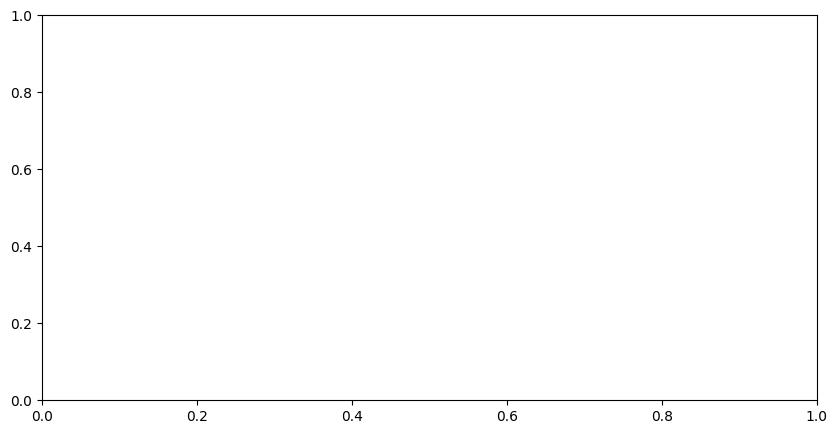

In [ ]:
fig, ax = plt.subplots(figsize = (10,5))
ax.plot(time, final_test_accuracies, label = "train loss")
plt.show()

In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer):
  size = len(dataloader.dataset)
  batch_loss = 0.0
  model.train()
  for batch, (X, y) in enumerate(dataloader):
    if torch.cuda.is_available():
      X, y = X.to(device), y.to(device)
    pred = model(X)
    loss = loss_fn(pred, y.float()) #compare loss function with predited function

    loss.backward()
    optimizer.step() #update the parameter
    optimizer.zero_grad()

    if batch%1000 == 0:
      batch_loss, current = loss.item(), batch * BATCH_SIZE + len(X)
      print(f"loss: {batch_loss:>7f} [{current:>5d}/{size:>5d}]")
  return batch_loss

# Recurrent Neural Network
A Rnn take the actoivation of the previous and pass it to the next
For each node, the model once again takes into account each feature vector  x . However, instead of processing them all at once, we would process them on different timesteps. For the first time step, we perform linear operation then apply activation function on the very first feature (word)  x1  to obtain a a hidden output  h1 . The hidden output of the first timestep will be considered into the next time step, and so on. To describe this mathematically:

In [ ]:
OUTPUT_SIZE = 1
HIDDEN_SIZE = 256
NUM_LAYERS = 3
BATCH_SIZE = 128
NUM_EPOCHS = 10

In [ ]:
class RNN(nn.Module):
  def __init__(self, output_size, embedding_dim, hidden_size, num_layers, dropout=0.5):
    super(RNN, self).__init__()
    self.embedding = nn.Embedding.from_pretrained(embedding_matrix)
    self.rnn = nn.RNN(
        input_size=embedding_dim,
        hidden_size=hidden_size,
        num_layers=num_layers,
        nonlinearity='relu',
        batch_first=True,
        dropout=dropout,
        bidirectional=False,
      )
    self.out_layer = nn.Sequential(
      nn.Dropout(p=dropout),
      nn.Linear(in_features=hidden_size, out_features=output_size, bias=False),
      nn.Sigmoid()
    )

  def forward(self, input):
    emb = self.embedding(input)
    out, hidden = self.rnn(emb)
    out = self.out_layer(out[:,-1,:])
    return out

rnn_model = RNN(OUTPUT_SIZE, EMBEDDINGS_DIM, HIDDEN_SIZE, NUM_LAYERS, 0.5).to(device)
print(rnn_model)


RNN(
  (embedding): Embedding(235888, 300)
  (rnn): RNN(300, 256, num_layers=3, batch_first=True, dropout=0.5, bidirectional=True)
  (out_layer): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=512, out_features=1, bias=False)
    (2): Sigmoid()
  )
)


In [ ]:
rnn_loss_fn = nn.BCELoss()
rnn_optimizer = torch.optim.Adam(rnn_model.parameters(), lr=1e-4, weight_decay=1e-5)
epochs = 10


for t in range(epochs):
  print(f"Epoch {t+1}\n---------------------------")
  train_loop(train_loader, rnn_model, rnn_loss_fn, rnn_optimizer)
  test_loop(val_loader, rnn_model, rnn_loss_fn)
print("Done")

Epoch 1
---------------------------
loss: 0.692876 [  128/1431702]
loss: 0.693478 [128128/1431702]
loss: 0.692567 [256128/1431702]
loss: 0.693922 [384128/1431702]
loss: 0.693016 [512128/1431702]
loss: 0.692016 [640128/1431702]
loss: 0.693671 [768128/1431702]
loss: 0.693117 [896128/1431702]
loss: 0.692682 [1024128/1431702]
loss: 0.693281 [1152128/1431702]
loss: 0.693668 [1280128/1431702]
loss: 0.693781 [1408128/1431702]
Test Error:
 Accuracy: 50.5%, Avg. loss: 0.693121

Epoch 2
---------------------------
loss: 0.694386 [  128/1431702]
loss: 0.693486 [128128/1431702]
loss: 0.693333 [256128/1431702]
loss: 0.692439 [384128/1431702]
loss: 0.693090 [512128/1431702]
loss: 0.693484 [640128/1431702]
loss: 0.693228 [768128/1431702]
loss: 0.692156 [896128/1431702]
loss: 0.693865 [1024128/1431702]
loss: 0.693780 [1152128/1431702]
loss: 0.693366 [1280128/1431702]
loss: 0.693238 [1408128/1431702]
Test Error:
 Accuracy: 50.5%, Avg. loss: 0.693112

Epoch 3
---------------------------
loss: 0.693258 [

# GRU(Gated recurrent unit)
With long sequences length, the simple RNN's performance can be worse because its long-term memory stored in the hidden state is affected by the noise in the data of more recent timestamp. Moreover, RNN only has recurrent connections to store long-term dependencies, which means that the gradients of a parameter may depend on many previous inputs and hidden outputs, causing the gradients to multiply or decay exponentially to zero (vanishing gradient). Because of this, it is common to switch to use the LTSM (long short-term memory) or GRU, its simplier alternative to safe guard this. Both structures utilized "gates" mechanism to decide to close/open for some input to be processed.

In [ ]:
OUTPUT_SIZE = 1
HIDDEN_SIZE = 256
NUM_LAYERS = 2
BATCH_SIZE = 128
NUM_EPOCHS = 30

In [ ]:
class GRU(nn.Module):
  def __init__(self, output_size, embedding_dim, hidden_size, num_layers, dropout=0.5):
    super(GRU, self).__init__()
    self.embedding = nn.Embedding.from_pretrained(embedding_matrix)
    self.gru = nn.GRU(
        input_size=embedding_dim,
        hidden_size=hidden_size,
        num_layers=num_layers,
        batch_first=True,
        dropout=dropout,
        bidirectional=True,
      )
    self.out_layer = nn.Sequential(
      nn.Dropout(p=dropout),
      nn.Linear(in_features=hidden_size*2, out_features=output_size, bias=False),
      nn.Sigmoid()
    )

  def forward(self, input):
    emb = self.embedding(input)
    out, hidden = self.gru(emb)
    out = self.out_layer(out[:,-1,:])
    return out

gru_model = GRU(OUTPUT_SIZE, EMBEDDINGS_DIM, HIDDEN_SIZE, NUM_LAYERS, 0.5).to(device)
print(gru_model)


GRU(
  (embedding): Embedding(235888, 300)
  (rnn): GRU(300, 256, num_layers=3, batch_first=True, dropout=0.5, bidirectional=True)
  (out_layer): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=512, out_features=1, bias=False)
    (2): Sigmoid()
  )
)


In [ ]:
gru_loss_fn = nn.BCELoss()
gru_optimizer = torch.optim.Adam(gru_model.parameters(), lr=1e-4, weight_decay=1e-5)
epochs = 10


for t in range(epochs):
  print(f"Epoch {t+1}\n---------------------------")
  train_loop(train_loader, gru_model, gru_loss_fn, gru_optimizer)
  test_loop(val_loader, gru_model, gru_loss_fn)
print("Done")

Epoch 1
---------------------------
loss: 0.695287 [  128/1431702]
loss: 0.467264 [128128/1431702]
loss: 0.522491 [256128/1431702]
loss: 0.386272 [384128/1431702]
loss: 0.503774 [512128/1431702]
loss: 0.420820 [640128/1431702]
loss: 0.473237 [768128/1431702]
loss: 0.470370 [896128/1431702]
loss: 0.435466 [1024128/1431702]
loss: 0.392570 [1152128/1431702]
loss: 0.473155 [1280128/1431702]
loss: 0.468656 [1408128/1431702]
Test Error:
 Accuracy: 78.4%, Avg. loss: 0.456510

Epoch 2
---------------------------
loss: 0.459801 [  128/1431702]
loss: 0.492194 [128128/1431702]
loss: 0.404335 [256128/1431702]
loss: 0.450941 [384128/1431702]
loss: 0.442067 [512128/1431702]
loss: 0.472401 [640128/1431702]
loss: 0.438805 [768128/1431702]
loss: 0.460042 [896128/1431702]
loss: 0.479059 [1024128/1431702]
loss: 0.405975 [1152128/1431702]
loss: 0.396197 [1280128/1431702]
loss: 0.455316 [1408128/1431702]
Test Error:
 Accuracy: 78.8%, Avg. loss: 0.447605

Epoch 3
---------------------------
loss: 0.460339 [

# LSTM(LONG SHORT TERM MEMORY)
solve the problem of vanishing gradient
for capturing relevant info in hidden layer for long sentance


In [ ]:
OUTPUT_SIZE = 1
HIDDEN_SIZE = 266
NUM_LAYERS = 2
BATCH_SIZE = 128
NUM_EPOCHS = 30

In [ ]:
class LSTMModel(nn.Module):
  def __init__(self, output_size, embedding_dim, hidden_size, num_layers, dropout=0.5):
    super().__init__()
    self.embedding = nn.Embedding.from_pretrained(embedding_matrix)
    self.lstm = nn.LSTM(
        input_size = embedding_dim,
        hidden_size = hidden_size,
        num_layers = num_layers,
        batch_first = True,
        dropout = dropout,
        bidirectional = False,
    )
    self.out_layer = nn.Sequential(
        nn.Dropout(p=dropout),
        nn.Linear(in_features=hidden_size, out_features=output_size, bias=False),
        nn.Sigmoid()
    )

  def forward(self, input):
    emb = self.embedding(input)
    out, h_n = self.lstm(emb)
    out = self.out_layer(out[:, -1, :])
    return out

lstm_model = LSTMModel(OUTPUT_SIZE, EMBEDDINGS_DIM, HIDDEN_SIZE, NUM_LAYERS, 0.5).to(device)
print(lstm_model)



LSTMModel(
  (embedding): Embedding(235888, 300)
  (lstm): LSTM(300, 266, num_layers=2, batch_first=True, dropout=0.5)
  (out_layer): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=266, out_features=1, bias=False)
    (2): Sigmoid()
  )
)


In [ ]:
lstm_loss_fn = nn.BCELoss()
lstm_optimizer = torch.optim.Adam(lstm_model.parameters(), lr=1e-4, weight_decay=1e-5)
epochs = 10


for t in range(epochs):
  print(f"Epoch {t+1}\n---------------------------")
  train_loop(train_loader, lstm_model, lstm_loss_fn, lstm_optimizer)
  test_loop(val_loader, lstm_model, lstm_loss_fn)
print("Done")

Epoch 1
---------------------------
loss: 0.692826 [  128/1431702]
loss: 0.576645 [128128/1431702]
loss: 0.543659 [256128/1431702]
loss: 0.408855 [384128/1431702]
loss: 0.520654 [512128/1431702]
loss: 0.423933 [640128/1431702]
loss: 0.526496 [768128/1431702]
loss: 0.474586 [896128/1431702]
loss: 0.478957 [1024128/1431702]
loss: 0.418925 [1152128/1431702]
loss: 0.496184 [1280128/1431702]
loss: 0.421587 [1408128/1431702]
Test Error:
 Accuracy: 78.0%, Avg. loss: 0.458064

Epoch 2
---------------------------
loss: 0.449582 [  128/1431702]
loss: 0.478470 [128128/1431702]
loss: 0.428480 [256128/1431702]
loss: 0.434037 [384128/1431702]
loss: 0.434807 [512128/1431702]
loss: 0.435041 [640128/1431702]
loss: 0.505207 [768128/1431702]
loss: 0.352859 [896128/1431702]
loss: 0.460270 [1024128/1431702]
loss: 0.444475 [1152128/1431702]
loss: 0.446672 [1280128/1431702]
loss: 0.483529 [1408128/1431702]
Test Error:
 Accuracy: 78.8%, Avg. loss: 0.445736

Epoch 3
---------------------------
loss: 0.512494 [